In [1]:
import gc
gc.collect()

0

In [2]:
import os
import random
from tqdm import tqdm


import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# loading data

data_dir = '../data'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

print(train_dataset)
type(train_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train


torchvision.datasets.mnist.FashionMNIST

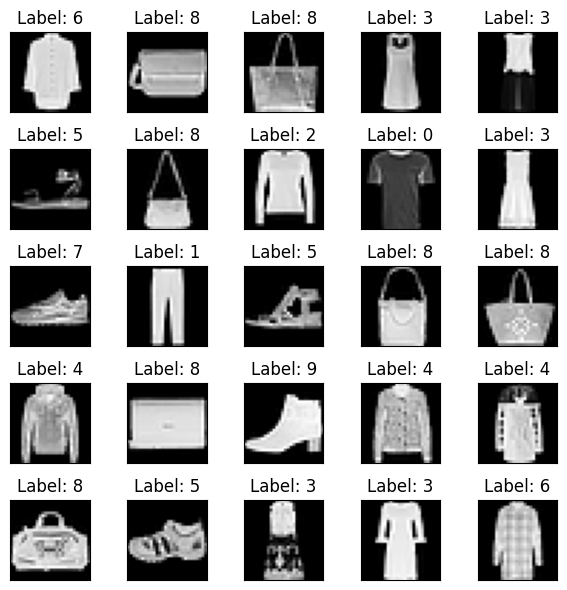

In [4]:
# display images examples

fig, axs = plt.subplots(5, 5, figsize=(6,6))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
# data to tensors

train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [6]:
# adding validation split

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(len(train_dataset)*0.8), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        # Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        # Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim=128):
        super().__init__()

        # Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        # Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        # Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [9]:
# Set the random seed for reproducible results
torch.manual_seed(42)

# Initialize the two networks
dim = 4

encoder = Encoder(encoded_space_dim=dim, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=dim, fc2_input_dim=128)

In [10]:
# Example on the untrained model

img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [11]:
# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)

Selected device: cpu


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [12]:
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [13]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [14]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [15]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

	 partial train loss (single batch): 0.252832
	 partial train loss (single batch): 0.235747
	 partial train loss (single batch): 0.236400
	 partial train loss (single batch): 0.227767
	 partial train loss (single batch): 0.226510
	 partial train loss (single batch): 0.217970
	 partial train loss (single batch): 0.211242
	 partial train loss (single batch): 0.211075
	 partial train loss (single batch): 0.215251
	 partial train loss (single batch): 0.204518
	 partial train loss (single batch): 0.207401
	 partial train loss (single batch): 0.202006
	 partial train loss (single batch): 0.196923
	 partial train loss (single batch): 0.200778
	 partial train loss (single batch): 0.192220
	 partial train loss (single batch): 0.193445
	 partial train loss (single batch): 0.190146
	 partial train loss (single batch): 0.182744
	 partial train loss (single batch): 0.186428
	 partial train loss (single batch): 0.184977
	 partial train loss (single batch): 0.185015
	 partial train loss (single batch

	 partial train loss (single batch): 0.057432
	 partial train loss (single batch): 0.058123
	 partial train loss (single batch): 0.057994
	 partial train loss (single batch): 0.057142
	 partial train loss (single batch): 0.057372
	 partial train loss (single batch): 0.055668
	 partial train loss (single batch): 0.056072
	 partial train loss (single batch): 0.055275
	 partial train loss (single batch): 0.057095

 EPOCH 1/30 	 train loss 0.117 	 val loss 0.055


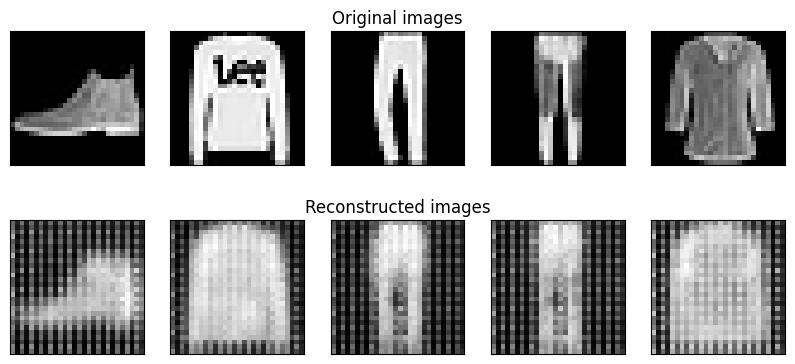

	 partial train loss (single batch): 0.056779
	 partial train loss (single batch): 0.053222
	 partial train loss (single batch): 0.056340
	 partial train loss (single batch): 0.053972
	 partial train loss (single batch): 0.054900
	 partial train loss (single batch): 0.053360
	 partial train loss (single batch): 0.050766
	 partial train loss (single batch): 0.052084
	 partial train loss (single batch): 0.053776
	 partial train loss (single batch): 0.051076
	 partial train loss (single batch): 0.052456
	 partial train loss (single batch): 0.052610
	 partial train loss (single batch): 0.051159
	 partial train loss (single batch): 0.051131
	 partial train loss (single batch): 0.051452
	 partial train loss (single batch): 0.050341
	 partial train loss (single batch): 0.049835
	 partial train loss (single batch): 0.049926
	 partial train loss (single batch): 0.050165
	 partial train loss (single batch): 0.049364
	 partial train loss (single batch): 0.049728
	 partial train loss (single batch

	 partial train loss (single batch): 0.030265
	 partial train loss (single batch): 0.031039
	 partial train loss (single batch): 0.030933
	 partial train loss (single batch): 0.032422
	 partial train loss (single batch): 0.030708
	 partial train loss (single batch): 0.029968
	 partial train loss (single batch): 0.030578
	 partial train loss (single batch): 0.029832
	 partial train loss (single batch): 0.031167

 EPOCH 2/30 	 train loss 0.038 	 val loss 0.030


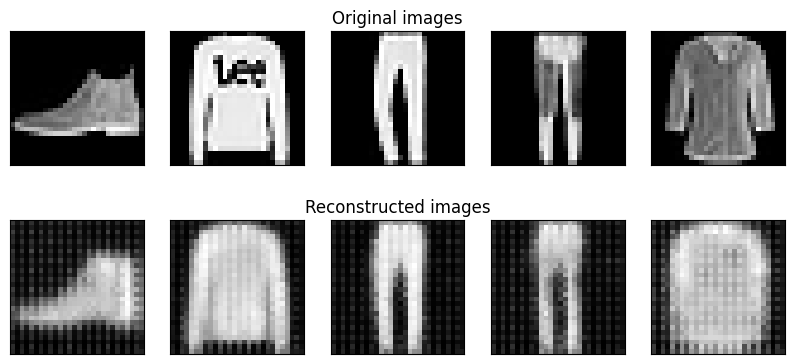

	 partial train loss (single batch): 0.031027
	 partial train loss (single batch): 0.029346
	 partial train loss (single batch): 0.031583
	 partial train loss (single batch): 0.029816
	 partial train loss (single batch): 0.030073
	 partial train loss (single batch): 0.030062
	 partial train loss (single batch): 0.028294
	 partial train loss (single batch): 0.029427
	 partial train loss (single batch): 0.030187
	 partial train loss (single batch): 0.029099
	 partial train loss (single batch): 0.029762
	 partial train loss (single batch): 0.030742
	 partial train loss (single batch): 0.030210
	 partial train loss (single batch): 0.028946
	 partial train loss (single batch): 0.031123
	 partial train loss (single batch): 0.028896
	 partial train loss (single batch): 0.028869
	 partial train loss (single batch): 0.030756
	 partial train loss (single batch): 0.029522
	 partial train loss (single batch): 0.028956
	 partial train loss (single batch): 0.028926
	 partial train loss (single batch

	 partial train loss (single batch): 0.025920
	 partial train loss (single batch): 0.025903
	 partial train loss (single batch): 0.027540
	 partial train loss (single batch): 0.025518
	 partial train loss (single batch): 0.024676
	 partial train loss (single batch): 0.025648
	 partial train loss (single batch): 0.024757
	 partial train loss (single batch): 0.025910

 EPOCH 3/30 	 train loss 0.027 	 val loss 0.025


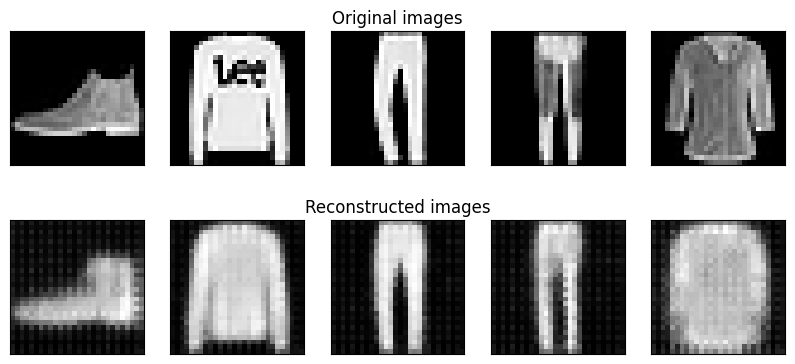

	 partial train loss (single batch): 0.025873
	 partial train loss (single batch): 0.024463
	 partial train loss (single batch): 0.026505
	 partial train loss (single batch): 0.025010
	 partial train loss (single batch): 0.024936
	 partial train loss (single batch): 0.025422
	 partial train loss (single batch): 0.023931
	 partial train loss (single batch): 0.024784
	 partial train loss (single batch): 0.025386
	 partial train loss (single batch): 0.024665
	 partial train loss (single batch): 0.025070
	 partial train loss (single batch): 0.026240
	 partial train loss (single batch): 0.025775
	 partial train loss (single batch): 0.024286
	 partial train loss (single batch): 0.026668
	 partial train loss (single batch): 0.024042
	 partial train loss (single batch): 0.024349
	 partial train loss (single batch): 0.026567
	 partial train loss (single batch): 0.024786
	 partial train loss (single batch): 0.024604
	 partial train loss (single batch): 0.024522
	 partial train loss (single batch

	 partial train loss (single batch): 0.023942
	 partial train loss (single batch): 0.025344
	 partial train loss (single batch): 0.023406
	 partial train loss (single batch): 0.022645
	 partial train loss (single batch): 0.023754
	 partial train loss (single batch): 0.022721
	 partial train loss (single batch): 0.023940

 EPOCH 4/30 	 train loss 0.024 	 val loss 0.023


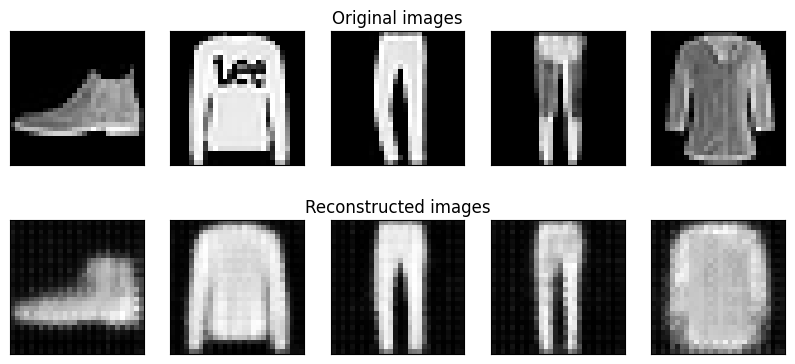

	 partial train loss (single batch): 0.023884
	 partial train loss (single batch): 0.022325
	 partial train loss (single batch): 0.024329
	 partial train loss (single batch): 0.023027
	 partial train loss (single batch): 0.022826
	 partial train loss (single batch): 0.023608
	 partial train loss (single batch): 0.022126
	 partial train loss (single batch): 0.022810
	 partial train loss (single batch): 0.023323
	 partial train loss (single batch): 0.022782
	 partial train loss (single batch): 0.023151
	 partial train loss (single batch): 0.024215
	 partial train loss (single batch): 0.023908
	 partial train loss (single batch): 0.022311
	 partial train loss (single batch): 0.024581
	 partial train loss (single batch): 0.022076
	 partial train loss (single batch): 0.022505
	 partial train loss (single batch): 0.024763
	 partial train loss (single batch): 0.022819
	 partial train loss (single batch): 0.022815
	 partial train loss (single batch): 0.022621
	 partial train loss (single batch

	 partial train loss (single batch): 0.022651
	 partial train loss (single batch): 0.022933
	 partial train loss (single batch): 0.024264
	 partial train loss (single batch): 0.022498
	 partial train loss (single batch): 0.021642
	 partial train loss (single batch): 0.022871
	 partial train loss (single batch): 0.021792
	 partial train loss (single batch): 0.022953

 EPOCH 5/30 	 train loss 0.023 	 val loss 0.022


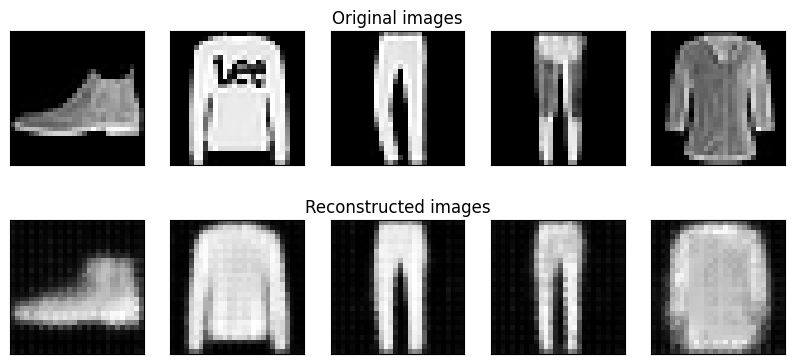

	 partial train loss (single batch): 0.022962
	 partial train loss (single batch): 0.021393
	 partial train loss (single batch): 0.023200
	 partial train loss (single batch): 0.022055
	 partial train loss (single batch): 0.021781
	 partial train loss (single batch): 0.022681
	 partial train loss (single batch): 0.021255
	 partial train loss (single batch): 0.021898
	 partial train loss (single batch): 0.022371
	 partial train loss (single batch): 0.021764
	 partial train loss (single batch): 0.022147
	 partial train loss (single batch): 0.023296
	 partial train loss (single batch): 0.023001
	 partial train loss (single batch): 0.021205
	 partial train loss (single batch): 0.023585
	 partial train loss (single batch): 0.021120
	 partial train loss (single batch): 0.021540
	 partial train loss (single batch): 0.024005
	 partial train loss (single batch): 0.021678
	 partial train loss (single batch): 0.021917
	 partial train loss (single batch): 0.021692
	 partial train loss (single batch

	 partial train loss (single batch): 0.022071
	 partial train loss (single batch): 0.022244
	 partial train loss (single batch): 0.023675
	 partial train loss (single batch): 0.021857
	 partial train loss (single batch): 0.021018
	 partial train loss (single batch): 0.022243
	 partial train loss (single batch): 0.021185
	 partial train loss (single batch): 0.022310

 EPOCH 6/30 	 train loss 0.022 	 val loss 0.022


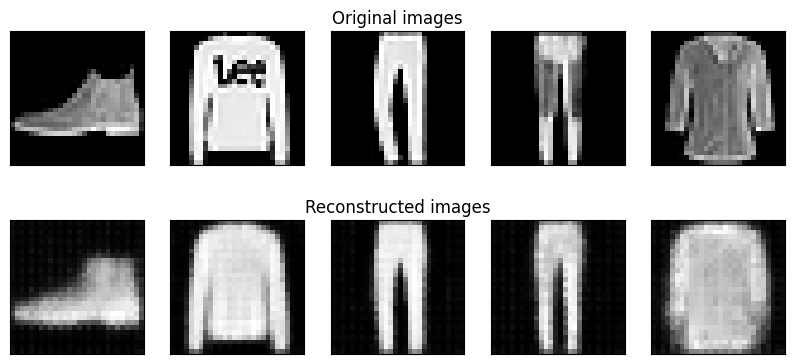

	 partial train loss (single batch): 0.022321
	 partial train loss (single batch): 0.020829
	 partial train loss (single batch): 0.022606
	 partial train loss (single batch): 0.021392
	 partial train loss (single batch): 0.021167
	 partial train loss (single batch): 0.022127
	 partial train loss (single batch): 0.020704
	 partial train loss (single batch): 0.021322
	 partial train loss (single batch): 0.021824
	 partial train loss (single batch): 0.021111
	 partial train loss (single batch): 0.021576
	 partial train loss (single batch): 0.022809
	 partial train loss (single batch): 0.022432
	 partial train loss (single batch): 0.020522
	 partial train loss (single batch): 0.022955
	 partial train loss (single batch): 0.020562
	 partial train loss (single batch): 0.020941
	 partial train loss (single batch): 0.023455
	 partial train loss (single batch): 0.020970
	 partial train loss (single batch): 0.021272
	 partial train loss (single batch): 0.021158
	 partial train loss (single batch

	 partial train loss (single batch): 0.023188
	 partial train loss (single batch): 0.021407
	 partial train loss (single batch): 0.020590
	 partial train loss (single batch): 0.021821
	 partial train loss (single batch): 0.020743
	 partial train loss (single batch): 0.021877

 EPOCH 7/30 	 train loss 0.021 	 val loss 0.021


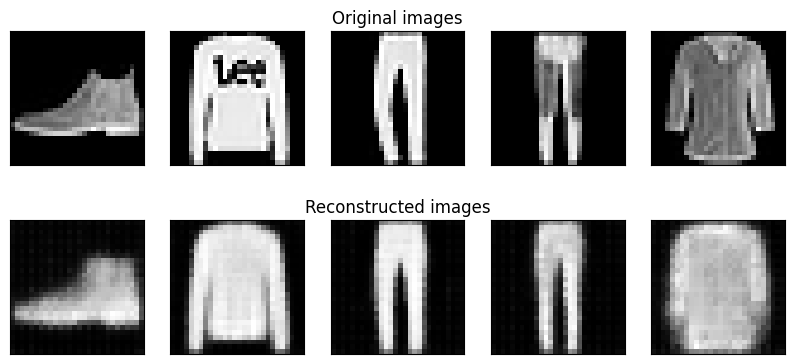

	 partial train loss (single batch): 0.021869
	 partial train loss (single batch): 0.020386
	 partial train loss (single batch): 0.022204
	 partial train loss (single batch): 0.020942
	 partial train loss (single batch): 0.020706
	 partial train loss (single batch): 0.021694
	 partial train loss (single batch): 0.020445
	 partial train loss (single batch): 0.020901
	 partial train loss (single batch): 0.021394
	 partial train loss (single batch): 0.020681
	 partial train loss (single batch): 0.021131
	 partial train loss (single batch): 0.022486
	 partial train loss (single batch): 0.022129
	 partial train loss (single batch): 0.020042
	 partial train loss (single batch): 0.022537
	 partial train loss (single batch): 0.020231
	 partial train loss (single batch): 0.020507
	 partial train loss (single batch): 0.023068
	 partial train loss (single batch): 0.020590
	 partial train loss (single batch): 0.020849
	 partial train loss (single batch): 0.020753
	 partial train loss (single batch

	 partial train loss (single batch): 0.022832
	 partial train loss (single batch): 0.021010
	 partial train loss (single batch): 0.020248
	 partial train loss (single batch): 0.021502
	 partial train loss (single batch): 0.020367
	 partial train loss (single batch): 0.021539

 EPOCH 8/30 	 train loss 0.021 	 val loss 0.021


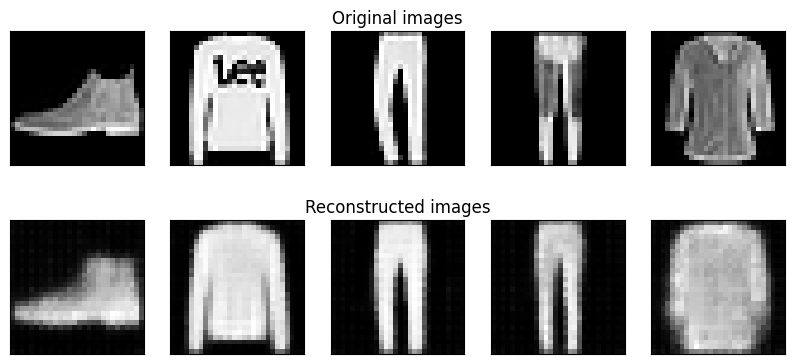

	 partial train loss (single batch): 0.021565
	 partial train loss (single batch): 0.020123
	 partial train loss (single batch): 0.021847
	 partial train loss (single batch): 0.020668
	 partial train loss (single batch): 0.020341
	 partial train loss (single batch): 0.021377
	 partial train loss (single batch): 0.020188
	 partial train loss (single batch): 0.020568
	 partial train loss (single batch): 0.021026
	 partial train loss (single batch): 0.020393
	 partial train loss (single batch): 0.020786
	 partial train loss (single batch): 0.022158
	 partial train loss (single batch): 0.021914
	 partial train loss (single batch): 0.019676
	 partial train loss (single batch): 0.022214
	 partial train loss (single batch): 0.019975
	 partial train loss (single batch): 0.020276
	 partial train loss (single batch): 0.022754
	 partial train loss (single batch): 0.020268
	 partial train loss (single batch): 0.020581
	 partial train loss (single batch): 0.020463
	 partial train loss (single batch

	 partial train loss (single batch): 0.020505
	 partial train loss (single batch): 0.021110
	 partial train loss (single batch): 0.021363
	 partial train loss (single batch): 0.022567
	 partial train loss (single batch): 0.020733
	 partial train loss (single batch): 0.019996
	 partial train loss (single batch): 0.021299
	 partial train loss (single batch): 0.020123
	 partial train loss (single batch): 0.021304

 EPOCH 9/30 	 train loss 0.021 	 val loss 0.021


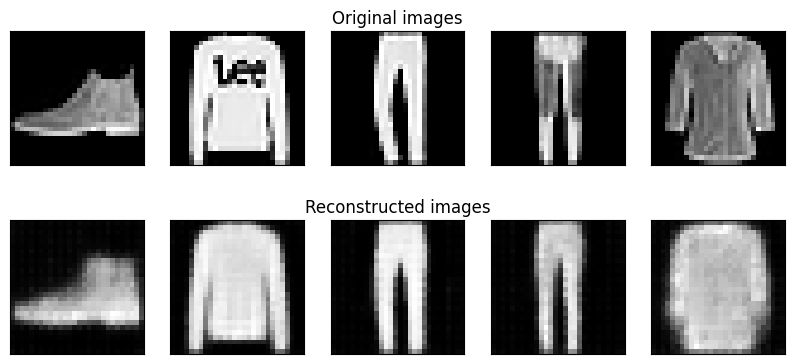

	 partial train loss (single batch): 0.021343
	 partial train loss (single batch): 0.019935
	 partial train loss (single batch): 0.021608
	 partial train loss (single batch): 0.020392
	 partial train loss (single batch): 0.020162
	 partial train loss (single batch): 0.021155
	 partial train loss (single batch): 0.019943
	 partial train loss (single batch): 0.020379
	 partial train loss (single batch): 0.020706
	 partial train loss (single batch): 0.020187
	 partial train loss (single batch): 0.020568
	 partial train loss (single batch): 0.021882
	 partial train loss (single batch): 0.021699
	 partial train loss (single batch): 0.019433
	 partial train loss (single batch): 0.021940
	 partial train loss (single batch): 0.019697
	 partial train loss (single batch): 0.020062
	 partial train loss (single batch): 0.022490
	 partial train loss (single batch): 0.019998
	 partial train loss (single batch): 0.020365
	 partial train loss (single batch): 0.020163
	 partial train loss (single batch

	 partial train loss (single batch): 0.020931
	 partial train loss (single batch): 0.021195
	 partial train loss (single batch): 0.022347
	 partial train loss (single batch): 0.020540
	 partial train loss (single batch): 0.019823
	 partial train loss (single batch): 0.021112
	 partial train loss (single batch): 0.019980
	 partial train loss (single batch): 0.021092

 EPOCH 10/30 	 train loss 0.020 	 val loss 0.020


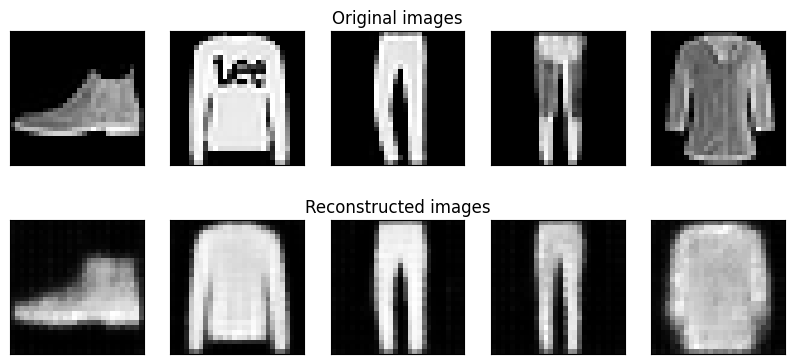

	 partial train loss (single batch): 0.021150
	 partial train loss (single batch): 0.019799
	 partial train loss (single batch): 0.021422
	 partial train loss (single batch): 0.020220
	 partial train loss (single batch): 0.019981
	 partial train loss (single batch): 0.020966
	 partial train loss (single batch): 0.019768
	 partial train loss (single batch): 0.020204
	 partial train loss (single batch): 0.020474
	 partial train loss (single batch): 0.019986
	 partial train loss (single batch): 0.020391
	 partial train loss (single batch): 0.021695
	 partial train loss (single batch): 0.021474
	 partial train loss (single batch): 0.019195
	 partial train loss (single batch): 0.021731
	 partial train loss (single batch): 0.019477
	 partial train loss (single batch): 0.019928
	 partial train loss (single batch): 0.022297
	 partial train loss (single batch): 0.019792
	 partial train loss (single batch): 0.020188
	 partial train loss (single batch): 0.019961
	 partial train loss (single batch

	 partial train loss (single batch): 0.020738
	 partial train loss (single batch): 0.021028
	 partial train loss (single batch): 0.022130
	 partial train loss (single batch): 0.020378
	 partial train loss (single batch): 0.019647
	 partial train loss (single batch): 0.020954
	 partial train loss (single batch): 0.019820
	 partial train loss (single batch): 0.020907

 EPOCH 11/30 	 train loss 0.020 	 val loss 0.020


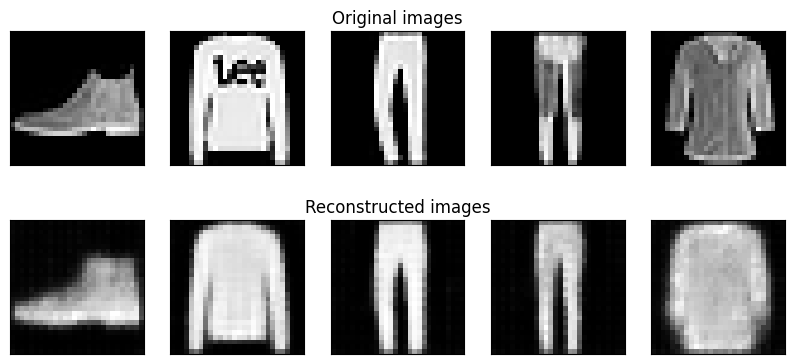

	 partial train loss (single batch): 0.021005
	 partial train loss (single batch): 0.019641
	 partial train loss (single batch): 0.021196
	 partial train loss (single batch): 0.020011
	 partial train loss (single batch): 0.019822
	 partial train loss (single batch): 0.020811
	 partial train loss (single batch): 0.019580
	 partial train loss (single batch): 0.020041
	 partial train loss (single batch): 0.020282
	 partial train loss (single batch): 0.019809
	 partial train loss (single batch): 0.020244
	 partial train loss (single batch): 0.021503
	 partial train loss (single batch): 0.021304
	 partial train loss (single batch): 0.019009
	 partial train loss (single batch): 0.021570
	 partial train loss (single batch): 0.019318
	 partial train loss (single batch): 0.019773
	 partial train loss (single batch): 0.022123
	 partial train loss (single batch): 0.019610
	 partial train loss (single batch): 0.020065
	 partial train loss (single batch): 0.019798
	 partial train loss (single batch

	 partial train loss (single batch): 0.020873
	 partial train loss (single batch): 0.021987
	 partial train loss (single batch): 0.020250
	 partial train loss (single batch): 0.019549
	 partial train loss (single batch): 0.020794
	 partial train loss (single batch): 0.019686
	 partial train loss (single batch): 0.020764

 EPOCH 12/30 	 train loss 0.020 	 val loss 0.020


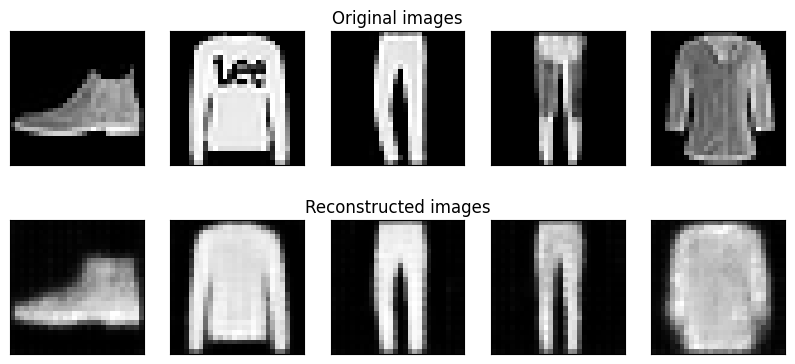

	 partial train loss (single batch): 0.020885
	 partial train loss (single batch): 0.019497
	 partial train loss (single batch): 0.021102
	 partial train loss (single batch): 0.019887
	 partial train loss (single batch): 0.019703
	 partial train loss (single batch): 0.020681
	 partial train loss (single batch): 0.019462
	 partial train loss (single batch): 0.019886
	 partial train loss (single batch): 0.020112
	 partial train loss (single batch): 0.019685
	 partial train loss (single batch): 0.020120
	 partial train loss (single batch): 0.021368
	 partial train loss (single batch): 0.021190
	 partial train loss (single batch): 0.018876
	 partial train loss (single batch): 0.021412
	 partial train loss (single batch): 0.019217
	 partial train loss (single batch): 0.019624
	 partial train loss (single batch): 0.021970
	 partial train loss (single batch): 0.019436
	 partial train loss (single batch): 0.019956
	 partial train loss (single batch): 0.019639
	 partial train loss (single batch

	 partial train loss (single batch): 0.020506
	 partial train loss (single batch): 0.020768
	 partial train loss (single batch): 0.021865
	 partial train loss (single batch): 0.020153
	 partial train loss (single batch): 0.019449
	 partial train loss (single batch): 0.020685
	 partial train loss (single batch): 0.019587
	 partial train loss (single batch): 0.020650

 EPOCH 13/30 	 train loss 0.020 	 val loss 0.020


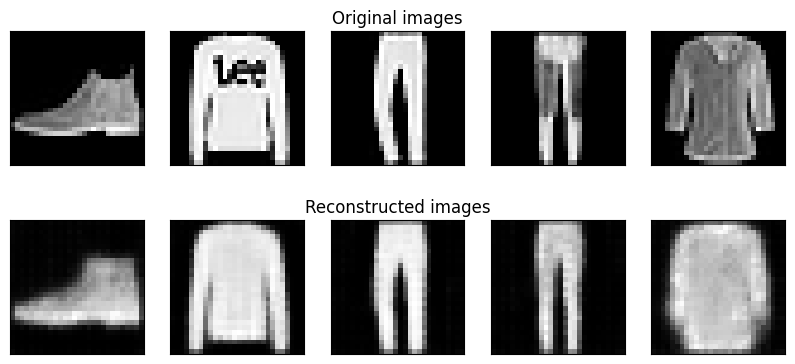

	 partial train loss (single batch): 0.020819
	 partial train loss (single batch): 0.019414
	 partial train loss (single batch): 0.021018
	 partial train loss (single batch): 0.019810
	 partial train loss (single batch): 0.019607
	 partial train loss (single batch): 0.020614
	 partial train loss (single batch): 0.019343
	 partial train loss (single batch): 0.019832
	 partial train loss (single batch): 0.020024
	 partial train loss (single batch): 0.019582
	 partial train loss (single batch): 0.020036
	 partial train loss (single batch): 0.021278
	 partial train loss (single batch): 0.021028
	 partial train loss (single batch): 0.018807
	 partial train loss (single batch): 0.021275
	 partial train loss (single batch): 0.019108
	 partial train loss (single batch): 0.019493
	 partial train loss (single batch): 0.021804
	 partial train loss (single batch): 0.019287
	 partial train loss (single batch): 0.019821
	 partial train loss (single batch): 0.019527
	 partial train loss (single batch

	 partial train loss (single batch): 0.020381
	 partial train loss (single batch): 0.020652
	 partial train loss (single batch): 0.021711
	 partial train loss (single batch): 0.020028
	 partial train loss (single batch): 0.019354
	 partial train loss (single batch): 0.020577
	 partial train loss (single batch): 0.019523
	 partial train loss (single batch): 0.020505

 EPOCH 14/30 	 train loss 0.020 	 val loss 0.020


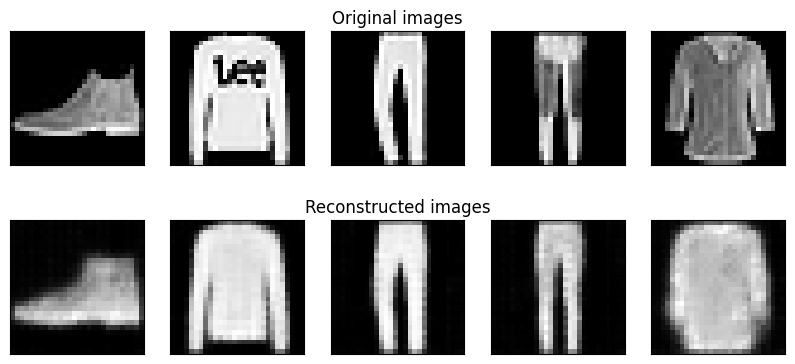

	 partial train loss (single batch): 0.020709
	 partial train loss (single batch): 0.019353
	 partial train loss (single batch): 0.020854
	 partial train loss (single batch): 0.019655
	 partial train loss (single batch): 0.019502
	 partial train loss (single batch): 0.020467
	 partial train loss (single batch): 0.019208
	 partial train loss (single batch): 0.019687
	 partial train loss (single batch): 0.019882
	 partial train loss (single batch): 0.019484
	 partial train loss (single batch): 0.019925
	 partial train loss (single batch): 0.021161
	 partial train loss (single batch): 0.020877
	 partial train loss (single batch): 0.018670
	 partial train loss (single batch): 0.021156
	 partial train loss (single batch): 0.019020
	 partial train loss (single batch): 0.019376
	 partial train loss (single batch): 0.021689
	 partial train loss (single batch): 0.019178
	 partial train loss (single batch): 0.019700
	 partial train loss (single batch): 0.019431
	 partial train loss (single batch

	 partial train loss (single batch): 0.019965
	 partial train loss (single batch): 0.019293
	 partial train loss (single batch): 0.020501
	 partial train loss (single batch): 0.019482
	 partial train loss (single batch): 0.020406

 EPOCH 15/30 	 train loss 0.020 	 val loss 0.020


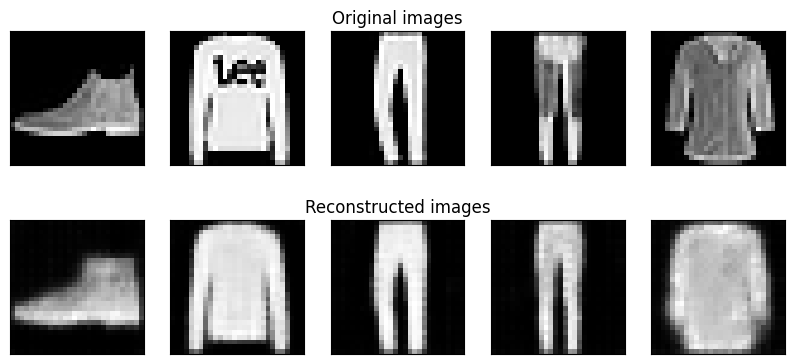

	 partial train loss (single batch): 0.020601
	 partial train loss (single batch): 0.019258
	 partial train loss (single batch): 0.020736
	 partial train loss (single batch): 0.019545
	 partial train loss (single batch): 0.019445
	 partial train loss (single batch): 0.020373
	 partial train loss (single batch): 0.019129
	 partial train loss (single batch): 0.019608
	 partial train loss (single batch): 0.019744
	 partial train loss (single batch): 0.019405
	 partial train loss (single batch): 0.019787
	 partial train loss (single batch): 0.021052
	 partial train loss (single batch): 0.020762
	 partial train loss (single batch): 0.018564
	 partial train loss (single batch): 0.021067
	 partial train loss (single batch): 0.018898
	 partial train loss (single batch): 0.019293
	 partial train loss (single batch): 0.021506
	 partial train loss (single batch): 0.019085
	 partial train loss (single batch): 0.019634
	 partial train loss (single batch): 0.019318
	 partial train loss (single batch

	 partial train loss (single batch): 0.020207
	 partial train loss (single batch): 0.020522
	 partial train loss (single batch): 0.021504
	 partial train loss (single batch): 0.019866
	 partial train loss (single batch): 0.019197
	 partial train loss (single batch): 0.020396
	 partial train loss (single batch): 0.019412
	 partial train loss (single batch): 0.020312

 EPOCH 16/30 	 train loss 0.020 	 val loss 0.020


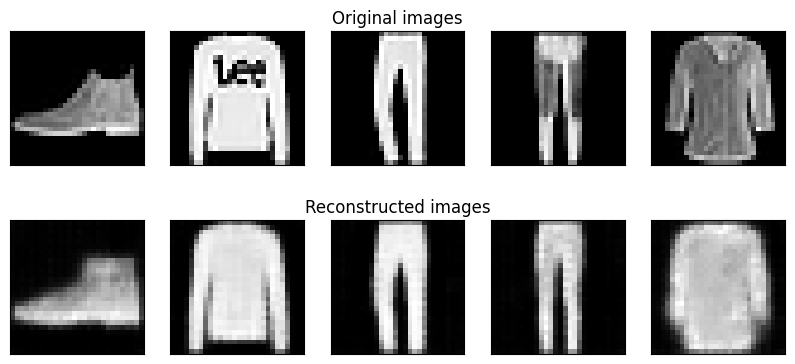

	 partial train loss (single batch): 0.020517
	 partial train loss (single batch): 0.019211
	 partial train loss (single batch): 0.020627
	 partial train loss (single batch): 0.019472
	 partial train loss (single batch): 0.019370
	 partial train loss (single batch): 0.020292
	 partial train loss (single batch): 0.019048
	 partial train loss (single batch): 0.019521
	 partial train loss (single batch): 0.019650
	 partial train loss (single batch): 0.019347
	 partial train loss (single batch): 0.019711
	 partial train loss (single batch): 0.020963
	 partial train loss (single batch): 0.020676
	 partial train loss (single batch): 0.018434
	 partial train loss (single batch): 0.020977
	 partial train loss (single batch): 0.018825
	 partial train loss (single batch): 0.019199
	 partial train loss (single batch): 0.021438
	 partial train loss (single batch): 0.018956
	 partial train loss (single batch): 0.019552
	 partial train loss (single batch): 0.019217
	 partial train loss (single batch

	 partial train loss (single batch): 0.019693
	 partial train loss (single batch): 0.020116
	 partial train loss (single batch): 0.020413
	 partial train loss (single batch): 0.021447
	 partial train loss (single batch): 0.019764
	 partial train loss (single batch): 0.019130
	 partial train loss (single batch): 0.020309
	 partial train loss (single batch): 0.019343
	 partial train loss (single batch): 0.020236

 EPOCH 17/30 	 train loss 0.020 	 val loss 0.020


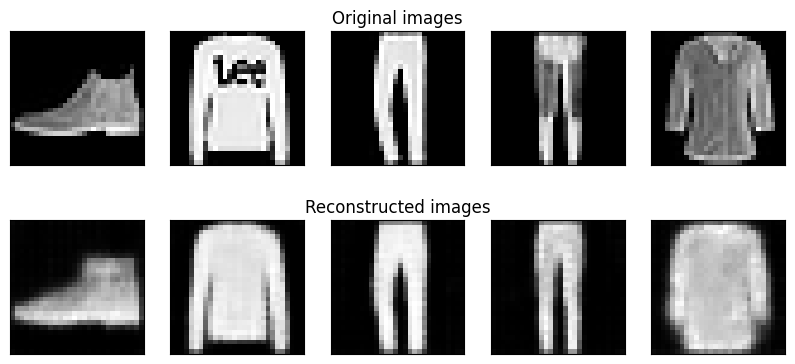

	 partial train loss (single batch): 0.020444
	 partial train loss (single batch): 0.019099
	 partial train loss (single batch): 0.020541
	 partial train loss (single batch): 0.019386
	 partial train loss (single batch): 0.019319
	 partial train loss (single batch): 0.020230
	 partial train loss (single batch): 0.018961
	 partial train loss (single batch): 0.019421
	 partial train loss (single batch): 0.019587
	 partial train loss (single batch): 0.019243
	 partial train loss (single batch): 0.019622
	 partial train loss (single batch): 0.020900
	 partial train loss (single batch): 0.020572
	 partial train loss (single batch): 0.018346
	 partial train loss (single batch): 0.020875
	 partial train loss (single batch): 0.018723
	 partial train loss (single batch): 0.019085
	 partial train loss (single batch): 0.021328
	 partial train loss (single batch): 0.018835
	 partial train loss (single batch): 0.019472
	 partial train loss (single batch): 0.019104
	 partial train loss (single batch

	 partial train loss (single batch): 0.021451
	 partial train loss (single batch): 0.019652
	 partial train loss (single batch): 0.019056
	 partial train loss (single batch): 0.020250
	 partial train loss (single batch): 0.019282
	 partial train loss (single batch): 0.020164

 EPOCH 18/30 	 train loss 0.019 	 val loss 0.020


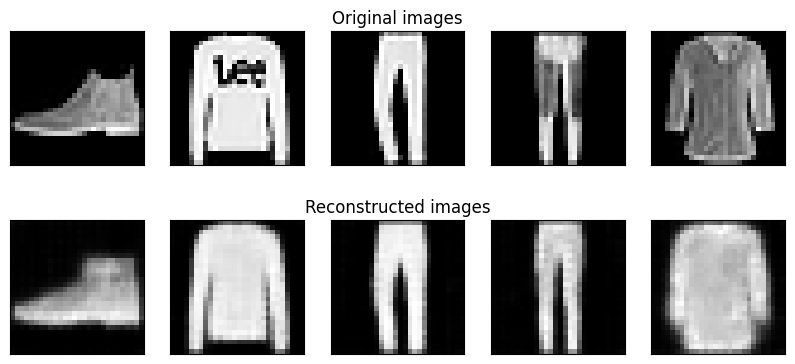

	 partial train loss (single batch): 0.020343
	 partial train loss (single batch): 0.019063
	 partial train loss (single batch): 0.020455
	 partial train loss (single batch): 0.019320
	 partial train loss (single batch): 0.019242
	 partial train loss (single batch): 0.020173
	 partial train loss (single batch): 0.018932
	 partial train loss (single batch): 0.019386
	 partial train loss (single batch): 0.019518
	 partial train loss (single batch): 0.019198
	 partial train loss (single batch): 0.019553
	 partial train loss (single batch): 0.020834
	 partial train loss (single batch): 0.020533
	 partial train loss (single batch): 0.018286
	 partial train loss (single batch): 0.020820
	 partial train loss (single batch): 0.018685
	 partial train loss (single batch): 0.019031
	 partial train loss (single batch): 0.021266
	 partial train loss (single batch): 0.018763
	 partial train loss (single batch): 0.019414
	 partial train loss (single batch): 0.019001
	 partial train loss (single batch

	 partial train loss (single batch): 0.020255
	 partial train loss (single batch): 0.021326
	 partial train loss (single batch): 0.019600
	 partial train loss (single batch): 0.019006
	 partial train loss (single batch): 0.020207
	 partial train loss (single batch): 0.019216
	 partial train loss (single batch): 0.020078

 EPOCH 19/30 	 train loss 0.019 	 val loss 0.020


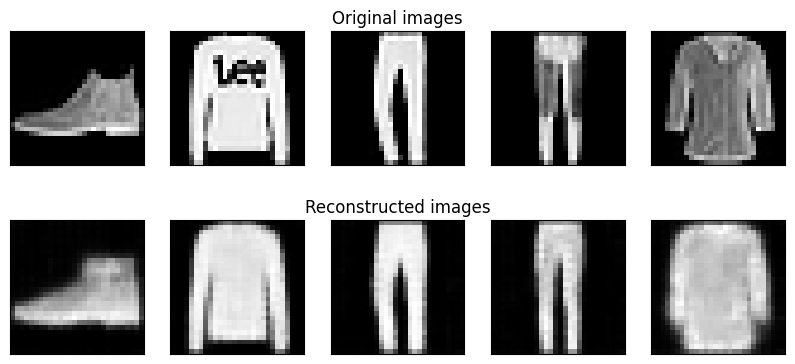

	 partial train loss (single batch): 0.020307
	 partial train loss (single batch): 0.018953
	 partial train loss (single batch): 0.020352
	 partial train loss (single batch): 0.019245
	 partial train loss (single batch): 0.019136
	 partial train loss (single batch): 0.020116
	 partial train loss (single batch): 0.018836
	 partial train loss (single batch): 0.019272
	 partial train loss (single batch): 0.019407
	 partial train loss (single batch): 0.019081
	 partial train loss (single batch): 0.019496
	 partial train loss (single batch): 0.020743
	 partial train loss (single batch): 0.020448
	 partial train loss (single batch): 0.018196
	 partial train loss (single batch): 0.020683
	 partial train loss (single batch): 0.018601
	 partial train loss (single batch): 0.018961
	 partial train loss (single batch): 0.021152
	 partial train loss (single batch): 0.018659
	 partial train loss (single batch): 0.019341
	 partial train loss (single batch): 0.018904
	 partial train loss (single batch

	 partial train loss (single batch): 0.021260
	 partial train loss (single batch): 0.019556
	 partial train loss (single batch): 0.018923
	 partial train loss (single batch): 0.020110
	 partial train loss (single batch): 0.019167
	 partial train loss (single batch): 0.019998

 EPOCH 20/30 	 train loss 0.019 	 val loss 0.020


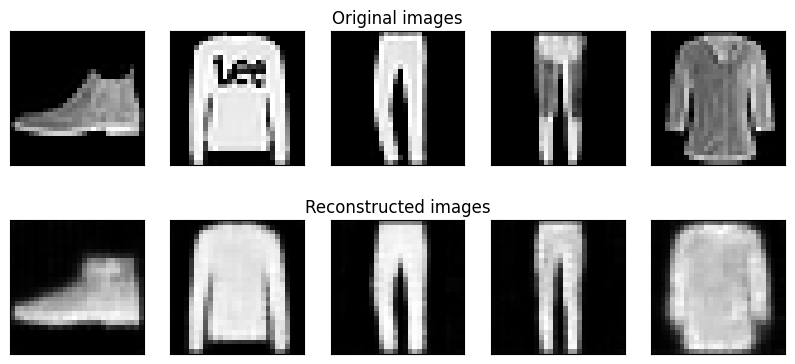

	 partial train loss (single batch): 0.020253
	 partial train loss (single batch): 0.018881
	 partial train loss (single batch): 0.020345
	 partial train loss (single batch): 0.019219
	 partial train loss (single batch): 0.019094
	 partial train loss (single batch): 0.020129
	 partial train loss (single batch): 0.018826
	 partial train loss (single batch): 0.019266
	 partial train loss (single batch): 0.019382
	 partial train loss (single batch): 0.019027
	 partial train loss (single batch): 0.019432
	 partial train loss (single batch): 0.020705
	 partial train loss (single batch): 0.020453
	 partial train loss (single batch): 0.018148
	 partial train loss (single batch): 0.020603
	 partial train loss (single batch): 0.018582
	 partial train loss (single batch): 0.018926
	 partial train loss (single batch): 0.021120
	 partial train loss (single batch): 0.018588
	 partial train loss (single batch): 0.019312
	 partial train loss (single batch): 0.018873
	 partial train loss (single batch

	 partial train loss (single batch): 0.021187
	 partial train loss (single batch): 0.019538
	 partial train loss (single batch): 0.018883
	 partial train loss (single batch): 0.020091
	 partial train loss (single batch): 0.019194
	 partial train loss (single batch): 0.019935

 EPOCH 21/30 	 train loss 0.019 	 val loss 0.020


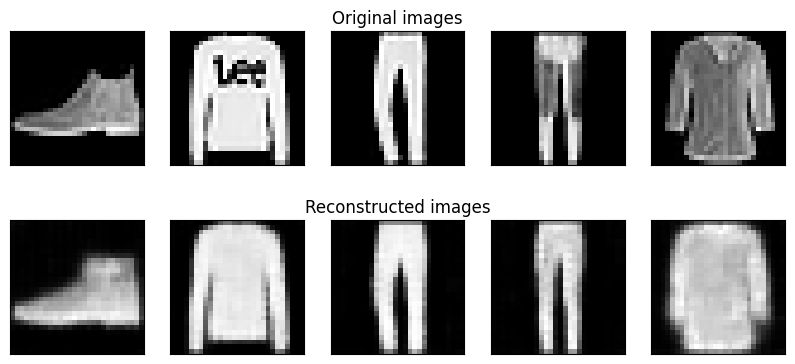

	 partial train loss (single batch): 0.020246
	 partial train loss (single batch): 0.018855
	 partial train loss (single batch): 0.020290
	 partial train loss (single batch): 0.019203
	 partial train loss (single batch): 0.019030
	 partial train loss (single batch): 0.020087
	 partial train loss (single batch): 0.018803
	 partial train loss (single batch): 0.019188
	 partial train loss (single batch): 0.019362
	 partial train loss (single batch): 0.018948
	 partial train loss (single batch): 0.019378
	 partial train loss (single batch): 0.020701
	 partial train loss (single batch): 0.020451
	 partial train loss (single batch): 0.018086
	 partial train loss (single batch): 0.020592
	 partial train loss (single batch): 0.018581
	 partial train loss (single batch): 0.018881
	 partial train loss (single batch): 0.021048
	 partial train loss (single batch): 0.018534
	 partial train loss (single batch): 0.019283
	 partial train loss (single batch): 0.018850
	 partial train loss (single batch

	 partial train loss (single batch): 0.021096
	 partial train loss (single batch): 0.019499
	 partial train loss (single batch): 0.018839
	 partial train loss (single batch): 0.019971
	 partial train loss (single batch): 0.019168
	 partial train loss (single batch): 0.019855

 EPOCH 22/30 	 train loss 0.019 	 val loss 0.020


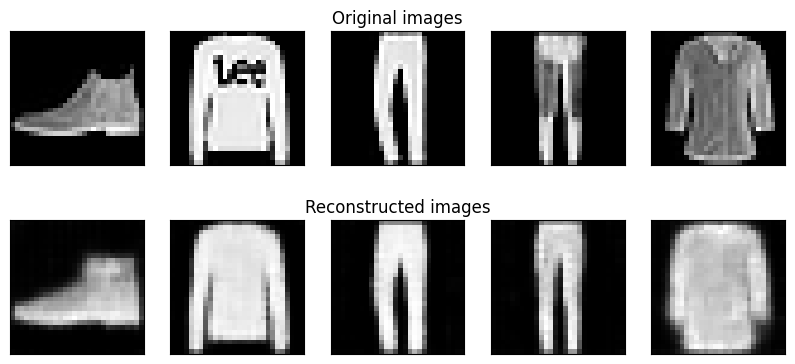

	 partial train loss (single batch): 0.020164
	 partial train loss (single batch): 0.018836
	 partial train loss (single batch): 0.020186
	 partial train loss (single batch): 0.019171
	 partial train loss (single batch): 0.018975
	 partial train loss (single batch): 0.019961
	 partial train loss (single batch): 0.018800
	 partial train loss (single batch): 0.019130
	 partial train loss (single batch): 0.019319
	 partial train loss (single batch): 0.018962
	 partial train loss (single batch): 0.019297
	 partial train loss (single batch): 0.020681
	 partial train loss (single batch): 0.020456
	 partial train loss (single batch): 0.018000
	 partial train loss (single batch): 0.020594
	 partial train loss (single batch): 0.018548
	 partial train loss (single batch): 0.018815
	 partial train loss (single batch): 0.021060
	 partial train loss (single batch): 0.018447
	 partial train loss (single batch): 0.019228
	 partial train loss (single batch): 0.018841
	 partial train loss (single batch

	 partial train loss (single batch): 0.019443
	 partial train loss (single batch): 0.018825
	 partial train loss (single batch): 0.019893
	 partial train loss (single batch): 0.019138
	 partial train loss (single batch): 0.019834

 EPOCH 23/30 	 train loss 0.019 	 val loss 0.019


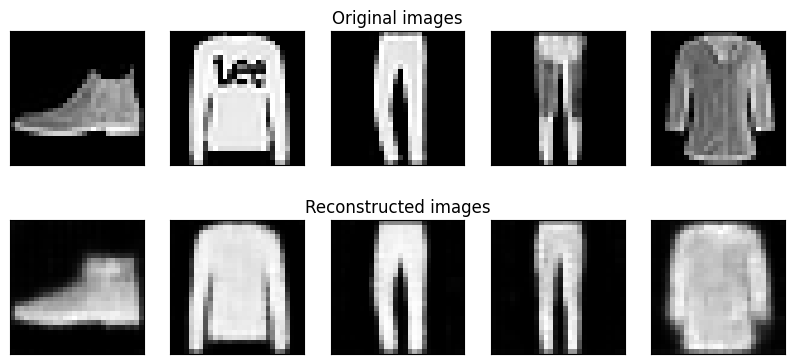

	 partial train loss (single batch): 0.020083
	 partial train loss (single batch): 0.018823
	 partial train loss (single batch): 0.020101
	 partial train loss (single batch): 0.019108
	 partial train loss (single batch): 0.018976
	 partial train loss (single batch): 0.019886
	 partial train loss (single batch): 0.018761
	 partial train loss (single batch): 0.019090
	 partial train loss (single batch): 0.019241
	 partial train loss (single batch): 0.018956
	 partial train loss (single batch): 0.019250
	 partial train loss (single batch): 0.020587
	 partial train loss (single batch): 0.020480
	 partial train loss (single batch): 0.017932
	 partial train loss (single batch): 0.020514
	 partial train loss (single batch): 0.018568
	 partial train loss (single batch): 0.018705
	 partial train loss (single batch): 0.020981
	 partial train loss (single batch): 0.018445
	 partial train loss (single batch): 0.019116
	 partial train loss (single batch): 0.018820
	 partial train loss (single batch

	 partial train loss (single batch): 0.019380
	 partial train loss (single batch): 0.018863
	 partial train loss (single batch): 0.019817
	 partial train loss (single batch): 0.019131
	 partial train loss (single batch): 0.019789

 EPOCH 24/30 	 train loss 0.019 	 val loss 0.019


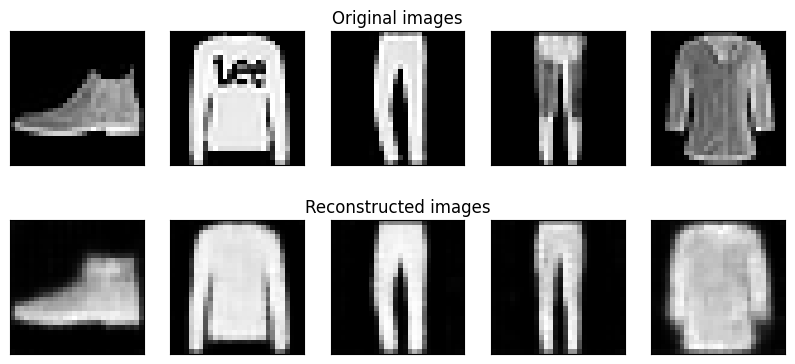

	 partial train loss (single batch): 0.020051
	 partial train loss (single batch): 0.018756
	 partial train loss (single batch): 0.020108
	 partial train loss (single batch): 0.019064
	 partial train loss (single batch): 0.018986
	 partial train loss (single batch): 0.019864
	 partial train loss (single batch): 0.018766
	 partial train loss (single batch): 0.019123
	 partial train loss (single batch): 0.019224
	 partial train loss (single batch): 0.018891
	 partial train loss (single batch): 0.019262
	 partial train loss (single batch): 0.020531
	 partial train loss (single batch): 0.020484
	 partial train loss (single batch): 0.017962
	 partial train loss (single batch): 0.020418
	 partial train loss (single batch): 0.018618
	 partial train loss (single batch): 0.018659
	 partial train loss (single batch): 0.020948
	 partial train loss (single batch): 0.018439
	 partial train loss (single batch): 0.019046
	 partial train loss (single batch): 0.018775
	 partial train loss (single batch

	 partial train loss (single batch): 0.019161
	 partial train loss (single batch): 0.019621
	 partial train loss (single batch): 0.019907
	 partial train loss (single batch): 0.021049
	 partial train loss (single batch): 0.019310
	 partial train loss (single batch): 0.018863
	 partial train loss (single batch): 0.019797
	 partial train loss (single batch): 0.019052
	 partial train loss (single batch): 0.019813

 EPOCH 25/30 	 train loss 0.019 	 val loss 0.019


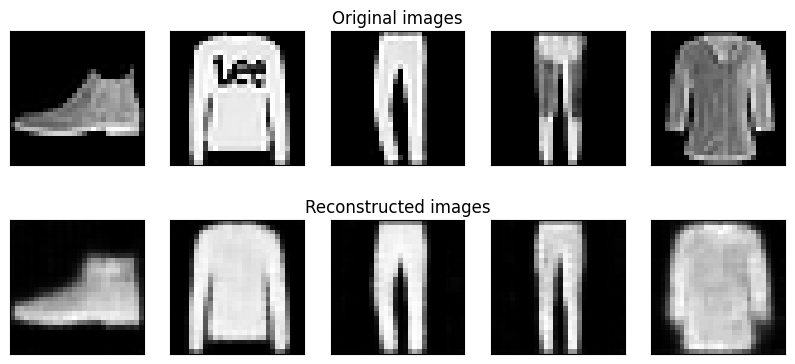

	 partial train loss (single batch): 0.020013
	 partial train loss (single batch): 0.018660
	 partial train loss (single batch): 0.020147
	 partial train loss (single batch): 0.018990
	 partial train loss (single batch): 0.018940
	 partial train loss (single batch): 0.019872
	 partial train loss (single batch): 0.018712
	 partial train loss (single batch): 0.019149
	 partial train loss (single batch): 0.019234
	 partial train loss (single batch): 0.018745
	 partial train loss (single batch): 0.019315
	 partial train loss (single batch): 0.020520
	 partial train loss (single batch): 0.020476
	 partial train loss (single batch): 0.018007
	 partial train loss (single batch): 0.020311
	 partial train loss (single batch): 0.018627
	 partial train loss (single batch): 0.018721
	 partial train loss (single batch): 0.020884
	 partial train loss (single batch): 0.018466
	 partial train loss (single batch): 0.018996
	 partial train loss (single batch): 0.018674
	 partial train loss (single batch

	 partial train loss (single batch): 0.019255
	 partial train loss (single batch): 0.018772
	 partial train loss (single batch): 0.019763
	 partial train loss (single batch): 0.018918
	 partial train loss (single batch): 0.019735

 EPOCH 26/30 	 train loss 0.019 	 val loss 0.019


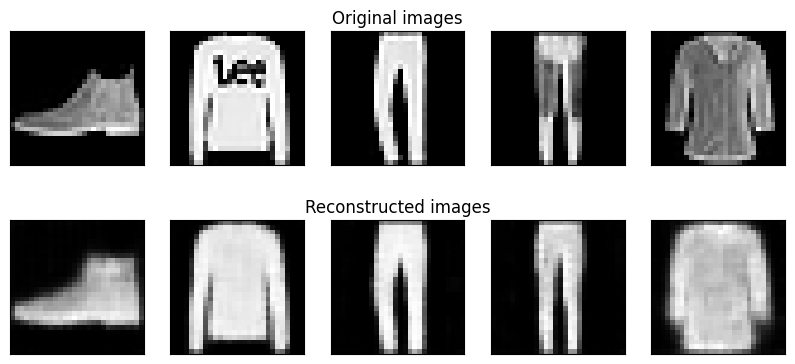

	 partial train loss (single batch): 0.019921
	 partial train loss (single batch): 0.018611
	 partial train loss (single batch): 0.020092
	 partial train loss (single batch): 0.018991
	 partial train loss (single batch): 0.018774
	 partial train loss (single batch): 0.019822
	 partial train loss (single batch): 0.018721
	 partial train loss (single batch): 0.018967
	 partial train loss (single batch): 0.019195
	 partial train loss (single batch): 0.018672
	 partial train loss (single batch): 0.019194
	 partial train loss (single batch): 0.020543
	 partial train loss (single batch): 0.020414
	 partial train loss (single batch): 0.017897
	 partial train loss (single batch): 0.020276
	 partial train loss (single batch): 0.018541
	 partial train loss (single batch): 0.018692
	 partial train loss (single batch): 0.020862
	 partial train loss (single batch): 0.018373
	 partial train loss (single batch): 0.018956
	 partial train loss (single batch): 0.018671
	 partial train loss (single batch

	 partial train loss (single batch): 0.019199
	 partial train loss (single batch): 0.018708
	 partial train loss (single batch): 0.019747
	 partial train loss (single batch): 0.018866
	 partial train loss (single batch): 0.019658

 EPOCH 27/30 	 train loss 0.019 	 val loss 0.019


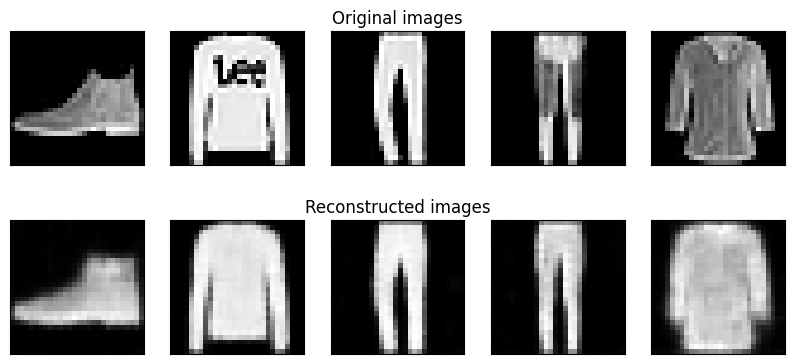

	 partial train loss (single batch): 0.019870
	 partial train loss (single batch): 0.018598
	 partial train loss (single batch): 0.019984
	 partial train loss (single batch): 0.018958
	 partial train loss (single batch): 0.018743
	 partial train loss (single batch): 0.019747
	 partial train loss (single batch): 0.018691
	 partial train loss (single batch): 0.018923
	 partial train loss (single batch): 0.019070
	 partial train loss (single batch): 0.018600
	 partial train loss (single batch): 0.019138
	 partial train loss (single batch): 0.020464
	 partial train loss (single batch): 0.020323
	 partial train loss (single batch): 0.017821
	 partial train loss (single batch): 0.020183
	 partial train loss (single batch): 0.018462
	 partial train loss (single batch): 0.018587
	 partial train loss (single batch): 0.020801
	 partial train loss (single batch): 0.018304
	 partial train loss (single batch): 0.018850
	 partial train loss (single batch): 0.018605
	 partial train loss (single batch

	 partial train loss (single batch): 0.018649
	 partial train loss (single batch): 0.019690
	 partial train loss (single batch): 0.018821
	 partial train loss (single batch): 0.019595

 EPOCH 28/30 	 train loss 0.019 	 val loss 0.019


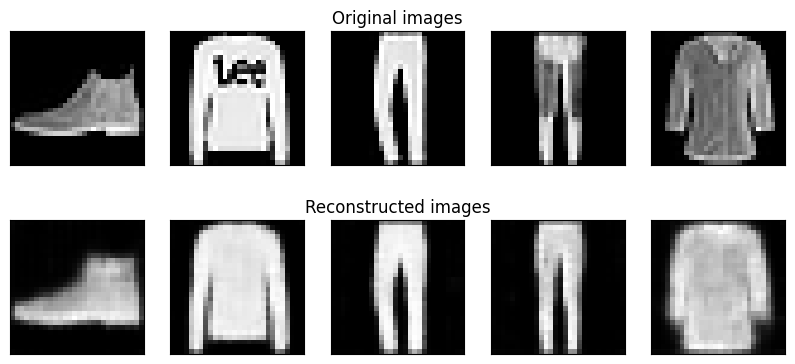

	 partial train loss (single batch): 0.019831
	 partial train loss (single batch): 0.018561
	 partial train loss (single batch): 0.019948
	 partial train loss (single batch): 0.018954
	 partial train loss (single batch): 0.018732
	 partial train loss (single batch): 0.019681
	 partial train loss (single batch): 0.018639
	 partial train loss (single batch): 0.018882
	 partial train loss (single batch): 0.019021
	 partial train loss (single batch): 0.018580
	 partial train loss (single batch): 0.019109
	 partial train loss (single batch): 0.020408
	 partial train loss (single batch): 0.020255
	 partial train loss (single batch): 0.017790
	 partial train loss (single batch): 0.020124
	 partial train loss (single batch): 0.018348
	 partial train loss (single batch): 0.018518
	 partial train loss (single batch): 0.020746
	 partial train loss (single batch): 0.018227
	 partial train loss (single batch): 0.018789
	 partial train loss (single batch): 0.018556
	 partial train loss (single batch

	 partial train loss (single batch): 0.018922
	 partial train loss (single batch): 0.019473
	 partial train loss (single batch): 0.019710
	 partial train loss (single batch): 0.020854
	 partial train loss (single batch): 0.019165
	 partial train loss (single batch): 0.018658
	 partial train loss (single batch): 0.019634
	 partial train loss (single batch): 0.018806
	 partial train loss (single batch): 0.019533

 EPOCH 29/30 	 train loss 0.019 	 val loss 0.019


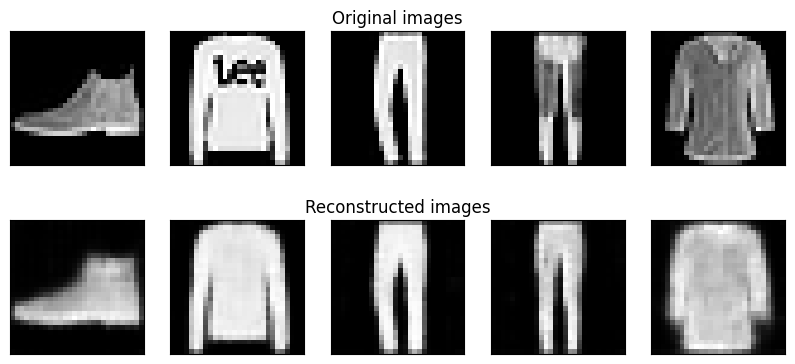

	 partial train loss (single batch): 0.019817
	 partial train loss (single batch): 0.018521
	 partial train loss (single batch): 0.019879
	 partial train loss (single batch): 0.018935
	 partial train loss (single batch): 0.018703
	 partial train loss (single batch): 0.019638
	 partial train loss (single batch): 0.018605
	 partial train loss (single batch): 0.018864
	 partial train loss (single batch): 0.018971
	 partial train loss (single batch): 0.018539
	 partial train loss (single batch): 0.019012
	 partial train loss (single batch): 0.020345
	 partial train loss (single batch): 0.020175
	 partial train loss (single batch): 0.017743
	 partial train loss (single batch): 0.020074
	 partial train loss (single batch): 0.018292
	 partial train loss (single batch): 0.018455
	 partial train loss (single batch): 0.020642
	 partial train loss (single batch): 0.018182
	 partial train loss (single batch): 0.018731
	 partial train loss (single batch): 0.018469
	 partial train loss (single batch

	 partial train loss (single batch): 0.019646
	 partial train loss (single batch): 0.020749
	 partial train loss (single batch): 0.019153
	 partial train loss (single batch): 0.018588
	 partial train loss (single batch): 0.019611
	 partial train loss (single batch): 0.018756
	 partial train loss (single batch): 0.019468

 EPOCH 30/30 	 train loss 0.019 	 val loss 0.019


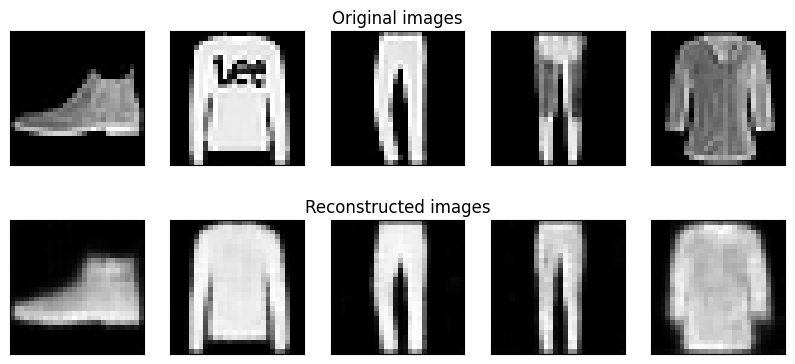

In [16]:
num_epochs = 30
history={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
    
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=5)

In [17]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.019240006804466248

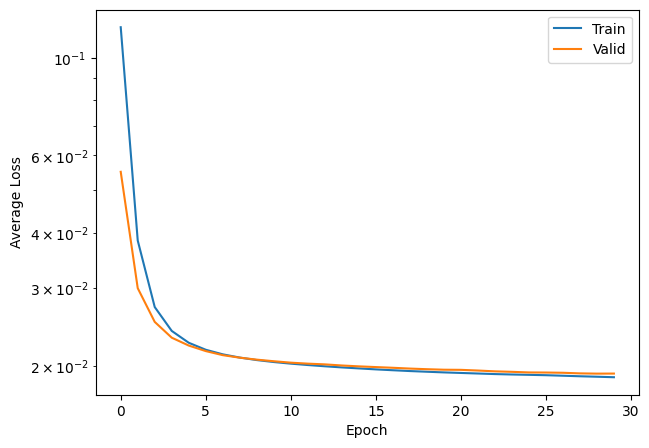

In [18]:
# Train and validation loss

plt.figure(figsize=(7,5))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.3652, -0.0589,  0.8125,  0.1935])
tensor([0.5865, 0.7306, 0.8967, 0.4532])


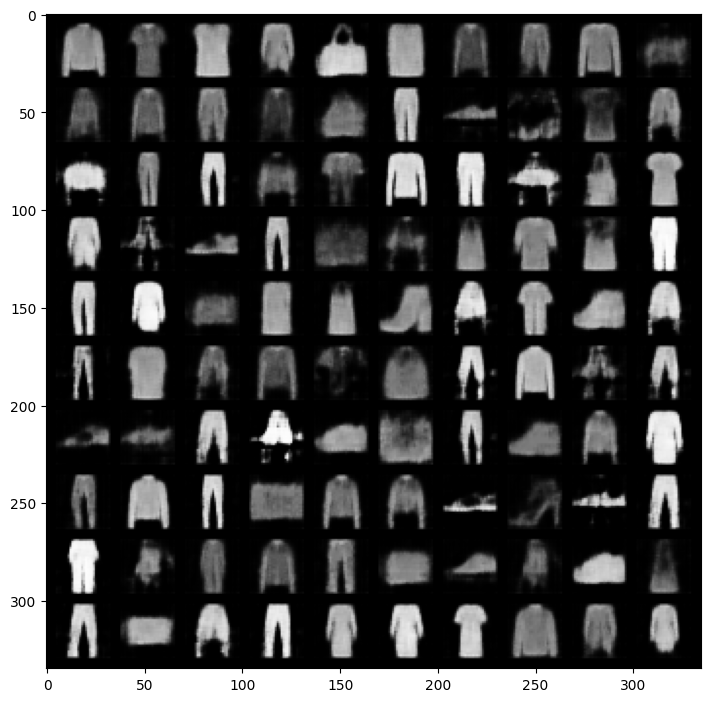

In [19]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_top_n(encoder, decoder, dataset, n=10):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # calculate mean and std of latent code, generated takining in test images as inputs 
        images, labels = map(list, zip(*[dataset[i] for i in range(10)]))
        images = torch.stack(images).to(device)
        latent = encoder(images)
        latent = latent.cpu()

        mean = latent.mean(dim=0)
        print(mean)
        std = (latent - mean).pow(2).mean(dim=0).sqrt()
        print(std)

        # sample latent vectors from the normal distribution
        latent = torch.randn(128, dim)*std + mean

        # reconstruct images from the random latent vectors
        latent = latent.to(device)
        img_recon = decoder(latent)
        img_recon = img_recon.cpu()

        fig, ax = plt.subplots(figsize=(20, 8.5))
        show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
        plt.show()
        
show_top_n(encoder, decoder, test_dataset, n=10)